**Fast Marching** :  
- Technique utilisée pour résoudre un problème spécifique : comment se déplacer d'un point à un autre le plus rapidement possible quand la vitesse de déplacement peut changer selon l'endroit où l'on se trouve
- Cette technique prend en compte les vitesses de déplacement selon les gradients de l'image
- Produit une carte de distance par rapport à un point source
- Les gradients entrent en jeu car ils sont utilisés pour définir cette métrique. Dans le contexte de l'image et du traitement du signal, les gradients (gx et gy dans notre exemple) sont utilisés pour détecter les changements d'intensité, qui peuvent correspondre à des contours ou à des bords dans une image. Ces contours ou bords peuvent représenter des barrières ou des frontières qui influencent la vitesse de déplacement dans l'algorithme de Fast Marching.

Premièrement, on installe les librairies qu'on va utiliser, et qui ne sont pas installées par défaut dans Google Colab :

In [ ]:
!pip install -q eikonalfm # Fast-Marching
!pip install -q ipympl # Intégration intéractive des figures matplotlib sur Colab

  On fait aussi les importations des bibliothèques nécessaires :

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter
import eikonalfm as fm
import cv2

from google.colab import output
output.enable_custom_widget_manager()

# Setup et définition des fonctions

On va définir dans cette partie toutes les fonctions qu'on va utiliser plus tard, lors de l'appel de la fonction du Fast-Marching

------

La première fonction `ind_to_coord` convertit un indice linéaire en un coupe de coordonnées dans une matrice bidimensionnelle. Un indice linéaire représente la position d'un élément dans une vue aplatie (ou linéarisée) de la matrice.

In [ ]:
def ind_to_coord(ind, n_rows, n_cols):
  return np.unravel_index(ind, (n_rows, n_cols))

# ----------
# Exemple
# ----------

# Tableau aplati : [0,1,2,3,4,5,6,7,8,9,10,11]
# ind_to_coord(6, 3, 4) -> (1,2)
# [[0, 1, 2, 3],
#  [4, 5, 6, 7],
#  [8, 9, 10, 11]]

La deuxième fonction `coord_to_ind` fait exactement l'inverse : elle permet de retrouver l'indice linéaire à partir d'un coupe de coordonnées d'un point dans une matrice bidimensionnelle

In [ ]:
def coord_to_ind(coord, n_rows, n_cols):
  return np.ravel_multi_index(coord, (n_rows, n_cols))

# ----------
# Exemple
# ----------

# [[0, 1, 2, 3],
#  [4, 5, 6, 7],
#  [8, 9, 10, 11]]

# coord_to_ind((1,2), 3, 4) -> 6
# Tableau aplati : [0,1,2,3,4,5,6,7,8,9,10,11]

La fonction `neigh_coord_to_ind` renvoie les indices linéaires des voisins d'un point dont on a rentré les coordonnées. Les voisins sont les 4 points (au dessus, en dessous, à gauche, et à droite d'un pixel).

Lorsqu'on va examiner les voisins des pixels, on va rencontrer un problème sur les bordures de l'image : en effet, sur la première ligne de l'image par exemple, les pixels n'auront pas de voisins du 'haut'.
Pour éviter ce problème, on va faire un `np.max([ix-1, 0])` qui va dans ce cas prend le maximum entre -1 et 0 (puisque `ix = 0` sur la première ligne), qui est égal à 0. On va donc prendre le point d'intérêt au lieu de son voisin du haut.
On fera de même pour les bordures inférieures, gauches, et droites ...

In [ ]:
def neigh_coord_to_ind(coord, n_rows, n_cols):
  ix, iy = coord
  return coord_to_ind([[np.max([ix-1, 0]), np.min([ix+1, n_rows-1]), ix, ix],
                       [iy, iy, np.max([iy-1, 0]), np.min([iy+1, n_cols-1])]],
                       n_rows, n_cols)

  # renvoie coord_to_ind([abscisse_voisin_haut, abscisse_voisin_bas, abscisse_voisin_gauche, abscisse_voisin_droit],
  #                       [ordonnée_voisin_haut, ordonnée_voisin_bas,ordonnée_voisin_gauche,ordonnée_voisin_droit])

  # ----------
  # Exemple
  # ----------

  # [0,1,2,
  #  3,4,5,
  #  6,7,8]
  #neigh_coord_to_ind((1,1),3,3) -> [1, 7, 3, 5]


La fonction `extract_curve` est très importante car c'est elle qui va extraire la courbe entre le point sur lequel on a calculé la carte de distance par `fast_marching`, et un autre point.

**Comment elle fonctionne ?**

Elle va démarrer d'un point `(end_point)`, et va remonter jusqu'au point source, sur lequel on a calculé la carte de distance.
Imaginez que vous placez un point sur une image `(point A)`, puis un second point sur la même image à un emplacement différent `(point B)`. Pour extraire le chemin le plus court reliant B à A (oui dans cet ordre), on va utiliser la carte de distance du point A. Cette carte de distance affichera toutes les distances de tout les points par rapport à A. On va donc démarrer de B, regarder ses 4 voisins, et sélectionner le point avec la plus petite distance par rapport à A (soit C). Une fois trouvé, on analyse les voisins de C, et ainsi de suite de manière itérative jusqu'à tomber sur le point A.  

In [ ]:
# Extraire un chemin/courbe a partir d'une carte de distance en remontant du point final vers la source (où la distance est nulle)
def extract_curve(dist_map, end_point):
  n_rows, n_cols = dist_map.shape
  curve = [(end_point[0], end_point[1])]
  u_min = dist_map[curve[-1]]
  while u_min != 0: # Tant que la distance n'est pas nulle, on remonte vers le point source en minimisant la distance
      neigh_ind = neigh_coord_to_ind(curve[-1], n_rows, n_cols)
      u = dist_map[ind_to_coord(neigh_ind, n_rows, n_cols)]
      arg_min = np.argmin(u) # Récupère l'indexe de la valeur minimale
      u_min = np.min(u) # Récupère la valeur minimale
      curve.append(ind_to_coord(neigh_ind[arg_min], n_rows, n_cols))

  return np.array(np.flip(curve, 0)) # Pour avoir l'ordre de points selon le sens : source -> point final

# Figure intéractive

Ces lignes de code permettent d'afficher une figure où l'on peut cliquer directement dessus sur le notebook, et sauvegarder les points dans une liste.

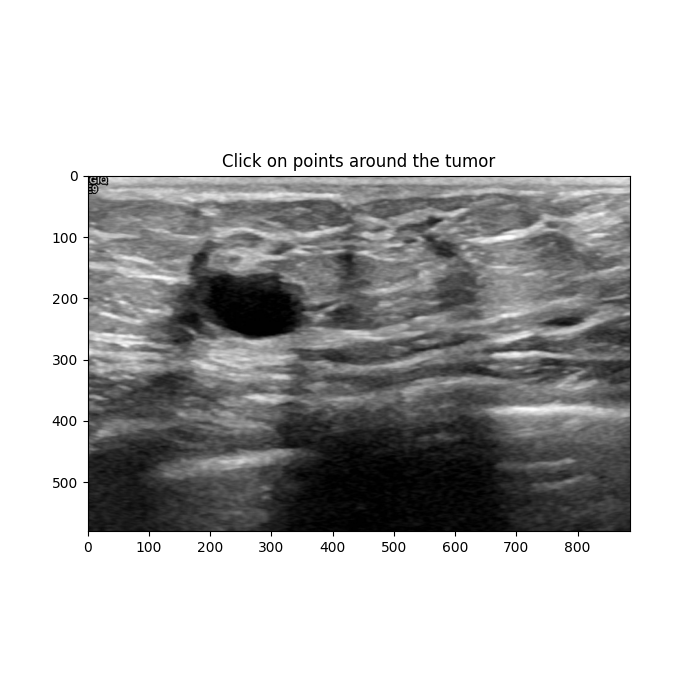

In [ ]:
%matplotlib ipympl
%matplotlib inline

fig = plt.figure(figsize=(7,7))
points = []

def onclick(event):
  if event.inaxes is not None : # Si le click de la souris a lieu à l'intérieur de la figure
    points.append([event.ydata, event.xdata])
    plt.scatter(int(event.xdata), int(event.ydata), marker = '+', c='y')
  else:
    print('Clicked outside of image axes')

img = cv2.imread('/content/benign (136).png')
mask = cv2.imread('/content/benign (136)_mask.png')

plt.imshow(img)
plt.title('Click on points around the tumor')

cid = fig.canvas.mpl_connect('button_press_event', onclick) # on connecte la figure à l'évènement

Voilà, vos points sont sauvegardés dans la variable `points` ! On peut continuer ...

# Fast-Marching

Avant de débuter l'étape du Fast-Marching, on va définir la notion de **gradient**.
Les gradients sont des indicateurs clés des zones de transition dans une image. En effet, un bord dans une image se caractérise par des variations d'intensité des pixels ; par conséquent, les gradients dans ces zones sont non nuls.

Voici un exemple ...

##Gradients

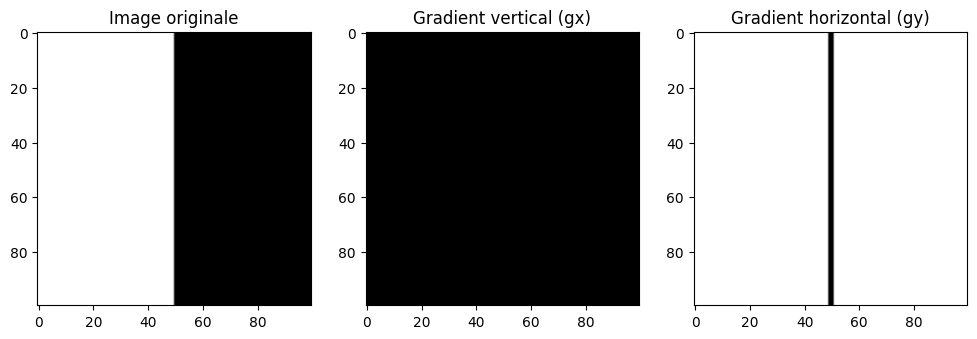

In [ ]:
# Initialisation d'une image, avec les 50 premières colonnes blanches
img = np.zeros((100,100))
img[:,:50] = 1

# Calcul des gradients sur les deux axes de l'image (x axe vertical, y axe horizontal)
gx, gy = np.gradient(img)

#Visualisation
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Image originale')

plt.subplot(1,3,2)
plt.imshow(gx, cmap='gray')
plt.title('Gradient vertical (gx)')

plt.subplot(1,3,3)
plt.imshow(gy, cmap='gray')
plt.title('Gradient horizontal (gy)')

plt.show()


Puisqu'il existe une **transition horizontal** entre la partie gauche, et la partie droite de l'image, le gradient dans cette direction (donc **gy**) sera non nulle, et correspond à la bande vertical dans notre exemple.

## Fast-Marching

Vient ensuite l'étape du **Fast-Marching** !

La fonction `fm.fast_marching` s'applique sur un point, et va renvoyer une carte de distances. Un Fast-Marching appliqué sur un point `x0` produira donc une carte de toutes les distances de tous les autres points de l'image par rapport à `x0`.

On va utiliser comme métrique **l'amplitude du gradient** : ça permet de mesurer l'intensité de la variation des intensités sur différentes zones de l'image. Traditionnellement, la vitesse de propagation est inversement proportionnelle aux gradients. Cela signifie que plus les transitions sont brusques (comme la bande verticale dans notre exemple sur les gradients), plus la vitesse de propagation diminue.

In [ ]:
points = np.round(points).astype('int')

img = cv2.imread('/content/benign (136).png').astype('float')/255
img = img[:,:,0]
gauss = gaussian_filter(img,1) # Lisser l'image et de réduire le bruit

gx = np.gradient(gauss, axis = 0) # Gradient vertical
gy = np.gradient(gauss, axis = 1) # Gradient horizontal

metric = 1/ (gx**2 + gy**2 + 1e-3)

start = time.time()
curves = []

On parcourt ensuite tous les points qu'on a mis manuellement.
Pour chaque point `xi`, on va regarder la carte de distance de ce point, et utiliser la fonction `extract_curve` pour relier le point `xi+1` à `xi` avec le chemin le plus court !
La fonction `extract_curve` va démarrer à `xi+1`, et va récupérer à l'aide de la carte de distance de `xi`, la plus petite distance vers `xi` !

In [ ]:
for i in range(len(points)-1):
  dist_map = fm.fast_marching(1/metric, points[i], (1,1), 2)
  curves.append(extract_curve(dist_map, points[i+1]))

dist_map = fm.fast_marching(1/metric, points[-1], (1,1),2)
curves.append(extract_curve(dist_map, points[0]))

print("Running time {:.2f}".format(time.time()-start))

## Résultats

On affiche ensuite:
- La carte de la **métrique**, pour visualiser les zones à fortes/lentes vitesses de propagation

- La carte de **distances** appliquée au dernier point (la zone bleu correspond à la zone la plus proche par rapport au point d'intérêt)

- Le résultat **Fast-Marching** comparé à l'annotation du médecin.


In [ ]:
# display result
fig = plt.figure(figsize=(20, 10))

plt.subplot(131), plt.imshow(metric, 'jet'), plt.title('Metric')
for c in curves: # on parcours chaque portion de courbe
    plt.plot(c[:, 1], c[:, 0], c='black')  #on plot tout les y (c[:,1]) on fonction des x(c[:,0])

plt.subplot(132), plt.imshow(dist_map, 'jet'), plt.title('Distance map')
for c in curves:
    plt.plot(c[:, 1], c[:, 0], c='r')
#plot les points qu'on a tracé
plt.scatter(points[:, 1], points[:, 0], c='y')

plt.subplot(133), plt.imshow(img, 'gray'), plt.title('Result')
for c in curves:
    plt.plot(c[:, 1], c[:, 0], c='r')
# plot le dernier point
# de coordonnées
plt.plot(c[-1, 1], c[-1, 0], c='r', label='Fast-Marching')

contours = find_contours(mask[:,:,0], 1)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], c='b', label='GT')
plt.legend()
plt.show()

## Conclusion

Bien adapté, le Fast- Marching s'avère être une méthode très efficace pour segmenter des structures d'intêrets. Sa grande précision, et sa rapidité d'éxécution, font de cette méthode un avantage de taille pour éviter les tâches chronophages comme l'annotation des données

